# Comparing two means: Unpaired t Test

## Data visualization

In [1]:
import numpy as np
from scipy import stats
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# data from Table 30.1 (page 295)
old = np.array([20.8, 2.8, 50, 33.3, 29.4, 38.9, 29.4, 52.6, 14.3])
young=np.array([45.5, 55, 60.7, 61.5, 61.1, 65.5, 42.9, 37.5])

In [3]:
k2, pval = stats.normaltest(old)
print('old', f"D'Agostino-Pearson omnibus K2={k2:.2f}", f"p-value={pval:.3f}", sep='\t')

k2, pval = stats.normaltest(young)
print('young', f"D'Agostino-Pearson omnibus K2={k2:.2f}", f"p-value={pval:.3f}", sep='\t')


tstat, pval = stats.shapiro(old)
print('old', "Shapiro-Wilk's normality test p-value", round(pval, 3), sep='\t')

tstat, pval = stats.shapiro(young)
print('young', "Shapiro-Wilk's normality test p-value", round(pval, 3), sep='\t')
# if the P value from a normality test is large, the data are not inconsistent with a Gaussian distribution 

old	D'Agostino-Pearson omnibus K2=0.11	p-value=0.947
young	D'Agostino-Pearson omnibus K2=1.75	p-value=0.418
old	Shapiro-Wilk's normality test p-value	0.9
young	Shapiro-Wilk's normality test p-value	0.238
C:\Users\Sébastien\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\Sébastien\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [4]:
pg.normality(old)

,W,pval,normal
0,0.970675,0.900443,True


In [5]:
pg.normality(young)

,W,pval,normal
0,0.890741,0.23777,True


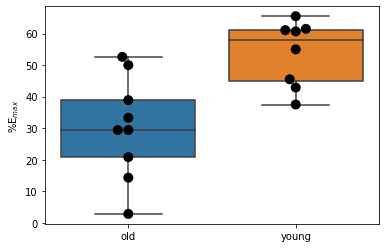

In [6]:
sns.boxplot(data=[old, young])
sns.swarmplot(data=[old, young], color='black', size=10)
plt.ylabel(r"%E$_{max}$")
plt.xticks([0,1], ['old', 'young']);

## Description of the data

### Unpaired two-sample T test using scipy

In [7]:
stats.ttest_ind(young, old, equal_var=False) # also called the Welch's t-test

Ttest_indResult(statistic=3.6242456851120375, pvalue=0.002828426914881655)

In [8]:
stats.ttest_ind(young, old, equal_var=True)

Ttest_indResult(statistic=3.531487707161938, pvalue=0.0030218492023012695)

### Unpaired (independent) two-sample T test using pingouin

pingouin just calls the scipy.ttest_ind method

In [9]:
pg.ttest(young, old, correction=False) # specify whether or not to correct for unequal variances using Welch separate variances T-test

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.531488,15,two-sided,0.003022,"[9.33, 37.76]",1.715995,12.56,0.909532


Because the 95% CI of the mean difference does not include zero, we are 95% confident that the mean response in old individuals is less than the mean response in young ones.

In [10]:
stats.describe(old)

DescribeResult(nobs=9, minmax=(2.8, 52.6), mean=30.16666666666667, variance=259.0375, skewness=-0.17569385392311104, kurtosis=-0.8080848898945967)

In [11]:
stats.describe(young)

DescribeResult(nobs=8, minmax=(37.5, 65.5), mean=53.7125, variance=107.4069642857143, skewness=-0.4421628669270582, kurtosis=-1.3632352105713499)

In [12]:
mean_diff = np.mean(young) - np.mean(old)
print(f"mean difference = {mean_diff:5.3f}")

mean difference = 23.546


### Testing the assumption of equal variances (_homoscedasticity_)

In [13]:
ratio_var = np.std(old, ddof=1) / np.std(young, ddof=1) # ratio of the variances of the two groups
print(f"The old individuals have an SD {ratio_var:.2f} times larger than that of young individuals.")

F_ratio = ratio_var**2
print(f"F ratio = {F_ratio:5.3f}")

p_val = 2 * (1 - stats.f.cdf(F_ratio, len(old)-1, len(young)-1)) # for two-sided (see Crawley, the R book, p.355)
print(f"P value for the F-test of equal variance={p_val:.4f}")

The old individuals have an SD 1.55 times larger than that of young individuals.
F ratio = 2.412
P value for the F-test of equal variance=0.2631


If H0 of equal variances were true, there would be a 26% chance that random sampling would result in this large discrepancy between the two SD values as observed here (or larger still).

What if the P value is small, indicating that the assumption of equal variances is unlikely to be true? There is no real consensus, but in biology we may ignore the result. The t-test is fairly robust to violations of the assumption of equal variances as long as the sample size isn't tiny and the two samples have an equal, or nearly equal, number of observations.

In [36]:
pg.homoscedasticity([young, old], method='levene') #test statistic W for Levene (using F-distribution), T for Bartlett (chi²)

,W,pval,equal_var
levene,0.686405,0.420378,True


### t ratio

The P value is computed from the _t ratio_ which is computed from the difference between the two sample means and the SD and sample size of each group, such as

$$t=(\overline x_1 - \overline x_2 - 0) / \sqrt{s^2(\frac{1}{n_1} + \frac{1}{n_2})}$$

writing differently:

$$t=(\overline x_1 - \overline x_2 - 0) / s.\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}$$

$$s^2=\frac{\sum_{i=1}^{n_1}(x_i - \overline x_1)^2 + \sum_{j=1}^{n_2}(x_j - \overline x_2)^2}{n_1+n_2-2}$$

where $\overline x_1$ and $\overline x_2$ are the sample means, $s^2$ is the **pooled sample variance**, $n_1$ and $n_2$ are the sample sizes and $t$ is a Student t quantile with $n_1 + n_2 - 2$ degrees of freedom (Df).

We can compute the **pooled standard deviation** as follows:

$$\sigma = \sqrt{\frac{(n_1-1)\sigma_1^2 + (n_2-1)\sigma_2^2}{n_1+n_2-2}}$$

In [81]:
Df = len(old) + len(young) - 2 # this is true only for equal variances, otherwise use Welch–Satterthwaite method

s_old = (len(old) - 1)*np.std(old,  ddof=1)**2
s_young=(len(young)-1)*np.std(young,ddof=1)**2
s_pooled = (s_old + s_young) / Df

t_ratio = mean_diff / ((1/len(old) + 1/len(young)) * s_pooled)**0.5
print(f"t ratio = {t_ratio:.5f} with {Df} degrees of freedom, assuming equal variance")

t ratio = 3.53149 with 15 degrees of freedom, assuming equal variance


#### t ratio for unequal variances

In [56]:
se_old = np.std(old, ddof=1)     / len(old)  **.5 # equivalent to stats.sem(old)
se_young = np.std(young, ddof=1) / len(young)**.5 # equivalent to stats.sem(young)
se_pooled = (s_old**2 + s_young**2)**.5

In [57]:
t_ratio = mean_diff / se_pooled
print(f"t ratio = {t_ratio:.5f}")

t ratio = 3.62425


This gives the t ratio as for unequal variances! For the situation of unequal variances, the Satterthwaite's approximate t test is used, a method in the Behrens-Welch family where $d$ is the Behrens-Welch test statistic evaluated as a Student t quantile with _df freedom using Satterthwaite's approximation_:

$$d=(\overline x_1 - \overline x_2) / \sqrt{(\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2})}$$

Note that is often more robust, i.e. in detecting difference between means, to use the nonparametric Mann-Whitney test as an alternative method in the presence of unequal variances.

### t statistic and Confidence Interval

In fact $t=(\overline x_1 - \overline x_2 - 0) / \text{SE}$.
In order to compute the CI, we need to obtain the **pooled standard error** $\text{SE} = s.\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}$

In [84]:
SE = s_pooled**.5 * (1/len(old) + 1/len(young))**.5
t_ = stats.t(df=Df).ppf((1+.95)/2) # two-tailed
CI_diff_mean = (mean_diff - t_ * SE, mean_diff + t_ * SE)

In [85]:
SE

6.667397789770537

In [89]:
print(f"the mean difference {mean_diff:.2f} CI (95%) extends from {CI_diff_mean[0]:.3f} to {CI_diff_mean[1]:.3f}")

the mean difference 23.55 CI (95%) extends from 9.335 to 37.757


### Rules of thumbs for interpreting error bars that overlap or not

|  Type  |    overlap    |  no overlap   |
| ------ | ------------- | ------------- |
|   SD   | no conclusion | no conclusion |
|  SEM   |   P > 0.05    | no conclusion |
| 95% CI | no conclusion |   P < 0.05    |

## Computing CI and P value with bootstraping

The P value is obtained by computing the sampling distribution of a test statistic under the null hypothesis and then, the percentile of the observed test statistic in the distribution.

Here H0 is that the data are equally distributed over the 2 groups, so H1 is that the groups are different, i.e. the difference of their means is different from 0.

For bootstraping we use permutation replicate, with the **test statistic being the difference between the means**. The P value is therefore the probability of obtaining a value of the test statistic that is at least as extreme as what observed, under the assumption of H0.

For testing for the same distribution, we use permutation test, for same mean, mean shifting as below.

### Mean Difference of the means and CI

In [90]:
# we create 10000 replicates of the difference of the means
bs_old = np.array([np.mean(np.random.choice(old, size=len(old))) for _ in range(10000)])
bs_young= np.array([np.mean(np.random.choice(young,size=len(young))) for _ in range(10000)])

bs_mean_diff = bs_young - bs_old

In [95]:
CI_mean_diff_bs = np.round(np.percentile(bs_mean_diff, [2.5, 97.5]), 2)
print(f"mean difference using bootstraping = {np.mean(bs_mean_diff):5.2f}")
print(f"corresponding 95% CI of the mean difference of the means = {CI_mean_diff_bs}")

mean difference using bootstraping = 23.54
corresponding 95% CI of the mean difference of the means = [11.46 35.82]


### Boostrap replicates

In [113]:
# We test H0 that data have the same mean
combined_mean = np.mean(np.concatenate([old, young]))

In [114]:
# We create shifts in both groups
young_shifted = young - np.mean(young) + combined_mean
old_shifted   = old   - np.mean(old)   + combined_mean

In [118]:
# We draw bootstrap replicates with same size as the original dataset
np.random.seed(999)
bs_shifted_young = np.array([np.mean(np.random.choice(young_shifted, size=len(young))) for _ in range(10000)])
bs_shifted_old   = np.array([np.mean(np.random.choice(old_shifted,   size=len(old)))   for _ in range(10000)])
bs_diff_shifted  = bs_shifted_young - bs_shifted_old # same test statistic as for the original difference of the means

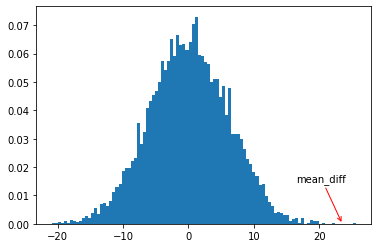

In [119]:
plt.hist(bs_diff_shifted, density=True, bins=100)
plt.annotate('mean_diff', xy=(mean_diff, 0), xytext=(mean_diff-7, .015),
            arrowprops={'arrowstyle': '->', 'color': 'red'});

In [120]:
P_value_bs = np.sum(bs_diff_shifted >= mean_diff) / len(bs_diff_shifted)
print(f"P value obtained using bootstraping = {P_value_bs:7.6f}")

P value obtained using bootstraping = 0.000100
